# 09. PyTorch Model Deployment

What is model deployment?
Machine learning model deployment is the act of making your machine learning model(s) available to someone or something

## Resources:
* Book version of notebook: https://www.learnpytorch.io/09_pytorch model deployment/
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorchmodel deployment.pdf

## 0. Get Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from param import output
from thinc.compat import torch_version

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [3]:
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [4]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline
### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible.

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper

## 3. Creating an EffNetB2 feature extractor
Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch -
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet

In [5]:
import torchvision

# Create an EffNetB2
effnetB2 = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)

for param in effnetB2.parameters():
    param.requires_grad = False

effnetB2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
summary(effnetB2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16

In [7]:
effnetB2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
set_seeds()
effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True),
)

### 3.1 Creating a function to make an EffNetB2 feature

In [9]:
def create_effnetb2_model(num_classes:int=3,# default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    transforms = weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=1000, bias=True),
    )

    return model, transforms

In [10]:
effnetB2_model, effnetB2_transforms = create_effnetb2_model()

In [11]:
summary(effnetB2_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [12]:
train_dataloader_effnetB2, test_dataloader_effnetB2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=effnetB2_transforms,
                                                                               test_transform=effnetB2_transforms,
                                                                               batch_size=32)

In [13]:
len(train_dataloader_effnetB2), len(test_dataloader_effnetB2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

#3.3 Training EffNetB2 feature extractor

In [14]:
from going_modular import data_setup, engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(effnetB2_model.parameters(), lr=0.001)

# Training function (engine.py)
set_seeds()
effnetB2_results = engine.train(
    effnetB2_model,
    train_dataloader_effnetB2,
    test_dataloader_effnetB2,
    optimizer,
    loss_fn,
    10,
    device
)

Epoch: 10 | train_loss: 0.4964 | train_acc: 0.9313 | test_loss: 0.5988 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves

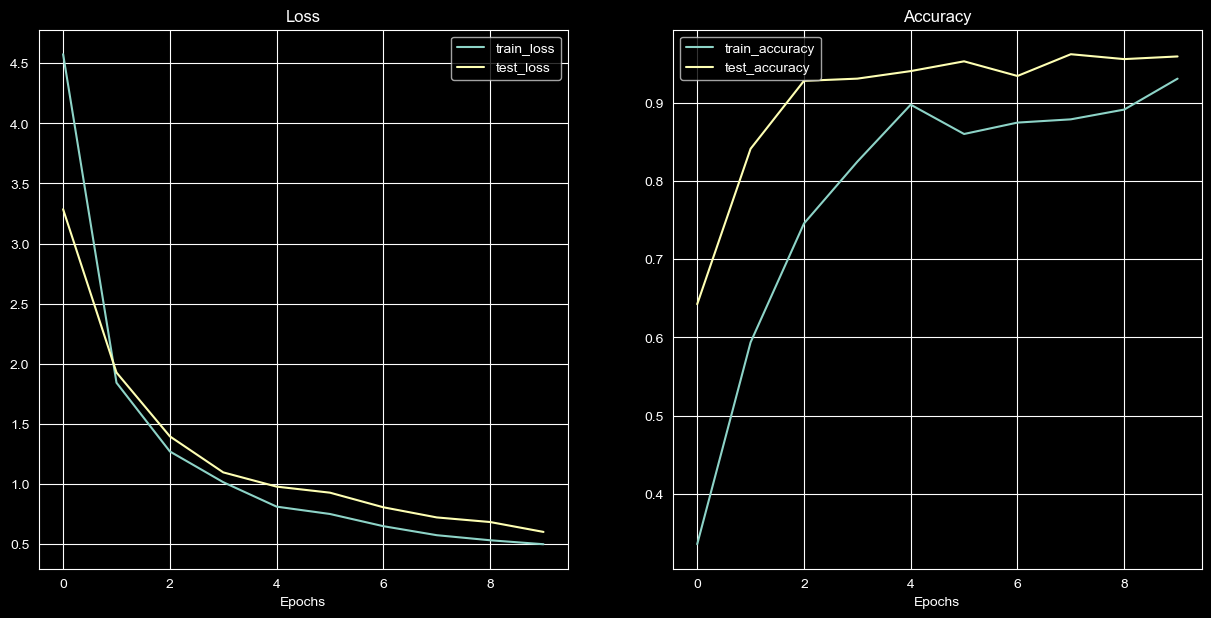

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_results)

See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 3.5 Saving EffNetB2 feature extracor

In [16]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetB2_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [17]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes
pretrained_effnetB2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024**2)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetB2_model_size:.2f}MB")

Pretrained EffNetB2 feature extractor model size: 35.22MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [18]:
# Count number of parameters in EffNetB2
effnetB2_total_params = sum(torch.numel(param) for param in effnetB2_model.parameters())
effnetB2_total_params

9109994

In [19]:
# Create a dictionary with EffNetB2 statistics
effnetB2_stats = {"test_loss": effnetB2_results["test_loss"][-1],
                  "test_acc": effnetB2_results["test_acc"][-1],
                  "total_params": effnetB2_total_params,
                  "model_size (MB)": pretrained_effnetB2_model_size
}
effnetB2_stats

{'test_loss': 0.5988291501998901,
 'test_acc': 0.959659090909091,
 'total_params': 9109994,
 'model_size (MB)': 35.21587562561035}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [20]:
# Check out the Vit heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [23]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    for parameter in model.parameters():
        parameter.requires_grad = False

    # Update the classifier head
    set_seeds(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    )

    return model, transforms

In [24]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
from torchinfo import summary

summary(model=vit_model,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [26]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [27]:
# Setup dataloaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       train_transform=vit_transforms,
                                                                                       test_transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor

In [28]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit_model,
                                      train_dataloader=train_dataloader_vit,
                                      test_dataloader=test_dataloader_vit,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

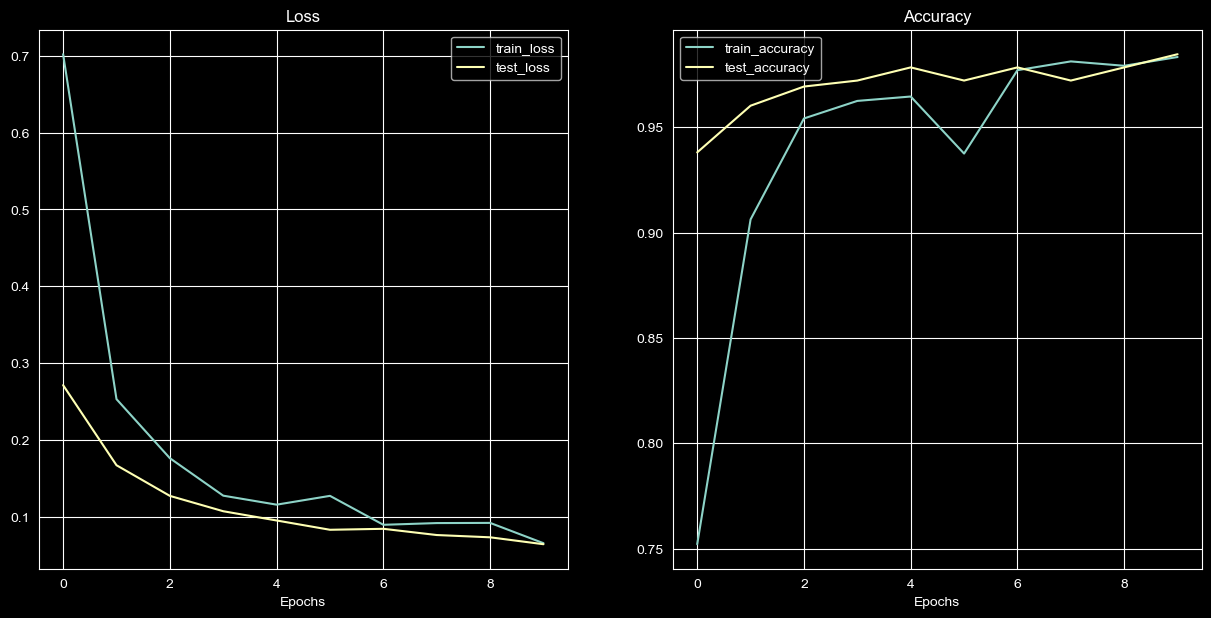

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 4.4 Saving Vit feature extractor

In [30]:
# Save model
from going_modular import utils

utils.save_model(
    model=vit_model,
    target_dir="models",
    model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"
)

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [31]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024**2)
print(f"Pretrained ViT feature extractor model size: {pretrained_effnetB2_model_size:.2f}MB")

Pretrained ViT feature extractor model size: 35.22MB


In [83]:
# Count number of parameters in EffNetB2
Vit_total_params = sum(torch.numel(param) for param in vit_model.parameters())
Vit_total_params

85800963

### 4.6 Collecting ViT feature extractor stats

In [84]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "total_params": Vit_total_params,
             "model_size (MB)": pretrained_vit_model_size
}
vit_stats

{'test_loss': 0.06443448159843683,
 'test_acc': 0.984659090909091,
 'total_params': 85800963,
 'model_size (MB)': 327.3689556121826}

## 5. Make predictions ith our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

In [85]:
from pathlib import Path
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

### 5.1 Creating  function to make across the test dataset

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. We can get the sample path and ground truth class from the file path
6. Start the prediction timer
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()`mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See oif the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list we created in step 2.
15. Return the list of prediction dictionary.

In [86]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: torch.device | str = "cpu") -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)
        transformed_img = transform(img).unsqueeze(0).to(device)

        model = model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_img)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_lable = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_lable.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our 'pred and_store() function.
Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with effnetb2_transforms)

In [87]:
# Make predictions test dataset with EffNetB2
effnetB2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetB2_model,
                                          transform=effnetB2_transforms,
                                          class_names=class_names,
                                          device=device)

  0%|          | 0/150 [00:00<?, ?it/s]

In [88]:
effnetB2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9162,
  'pred_class': 'steak',
  'time_for_pred': 0.7478,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9286,
  'pred_class': 'steak',
  'time_for_pred': 0.6965,
  'correct': True}]

In [89]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetB2_test_pred_df = pd.DataFrame (effnetB2_test_pred_dicts)
effnetB2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9162,steak,0.7478,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9286,steak,0.6965,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8756,steak,0.8433,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6136,steak,0.8802,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.2799,steak,0.6152,True


In [90]:
# Check number of correct predictions
effnetB2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [91]:
# Find the average time per prediction
effnetB2_average_time_per_pred = round(effnetB2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetB2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.7207


In [92]:
# Add average time per prediction to ViT stats
effnetB2_stats["time_per_pred_cpu"] = effnetB2_average_time_per_pred
effnetB2_stats

{'test_loss': 0.5988291501998901,
 'test_acc': 0.959659090909091,
 'total_params': 9109994,
 'model_size (MB)': 35.21587562561035,
 'time_per_pred_cpu': np.float64(0.7207)}

### 5.3 Making and timing predictions with ViT

In [93]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit_model,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy

  0%|          | 0/150 [00:00<?, ?it/s]

In [94]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7962,
  'pred_class': 'steak',
  'time_for_pred': 1.3594,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9981,
  'pred_class': 'steak',
  'time_for_pred': 0.388,
  'correct': True}]

In [95]:
# Turn vit_test_pred_dicts into a dataframe
import pandas as pd
vit_test_pred_df = pd.DataFrame (vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,1.3594,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.3880,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.4089,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.3657,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.3683,True


In [96]:
# See how many correct
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [97]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.4154


In [98]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443448159843683,
 'test_acc': 0.984659090909091,
 'total_params': 85800963,
 'model_size (MB)': 327.3689556121826,
 'time_per_pred_cpu': np.float64(0.4154)}

## 6. Comparing model results, prediction times and size

In [99]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetB2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to prcentage
df["test_acc"] = round(df["test_acc"]*100, 2)

df

,test_loss,test_acc,total_params,model_size (MB),time_per_pred_cpu,model
0,0.598829,95.97,9109994,35.215876,0.7207,EffNetB2
1,0.064434,98.47,85800963,327.368956,0.4154,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - if a model has more parameters, it generally takes longer to compute.
* *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_pre_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) - EffNefB2
Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [100]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"],
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,total_params,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.107601,1.02605,9.418334,9.296062,0.576384


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualise the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (model_size (MB)).

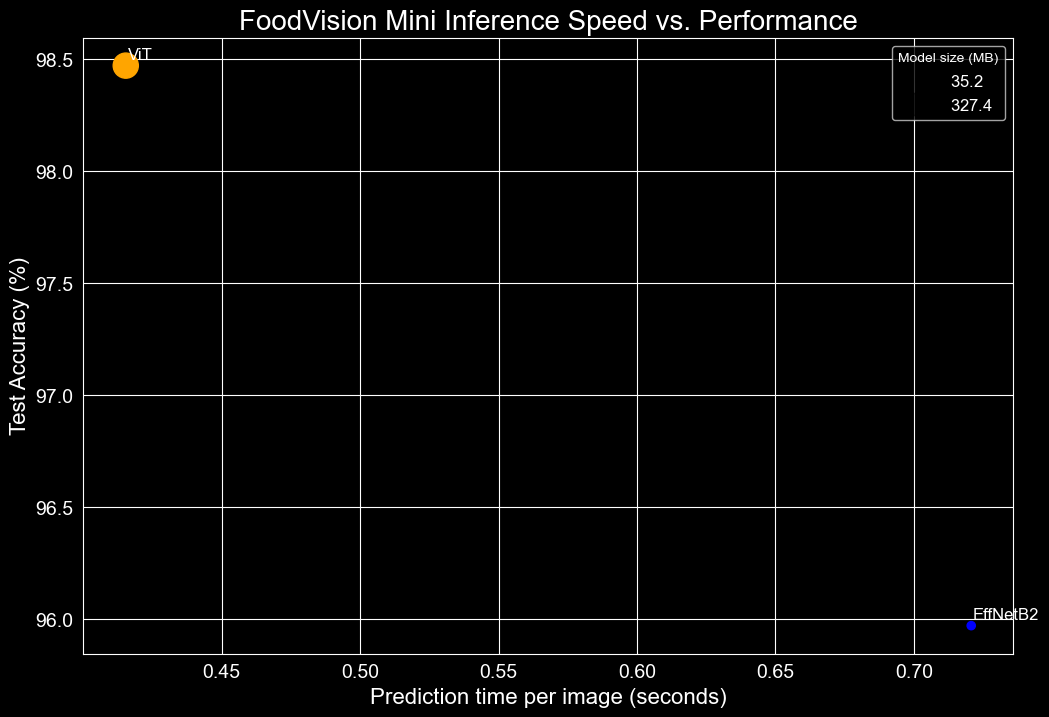

In [101]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs. Performance", fontsize=20)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=16)
ax.set_ylabel("Test Accuracy (%)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on the model sizes (model_size (MB)).
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles=handles,
                              labels=labels,
                              loc="upper right",
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
https://gradio.app/

In [107]:
import gradio as gr
gr.__version__

'5.49.1'

### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs and outputs

In [108]:
# Put our model on the cpu
effnetB2 = effnetB2.cpu()

# Check the device
next(iter(effnetB2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```images of food -> ML model (EffNetB2) -> outputs (food class label)```

In [116]:
from typing import Tuple, Dict
def predict(img) -> Tuple[Dict, float]:
    time = timer()
    transformed_img = effnetB2_transforms(img).unsqueeze(0).to("cpu")
    effnetB2_model.eval()
    with torch.no_grad():
        pred_probs = torch.softmax(effnetB2_model(transformed_img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    return pred_labels_and_probs, round(timer() - time, 4)


In [117]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the image
image = Image.open(random_image_path)
print (f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

{'pizza': 0.04641726613044739, 'steak': 0.7036461234092712, 'sushi': 0.24985671043395996}
2.1151


### 7.3 Creating list of example images
The examples for Gradio can be created with the `examples` parameter, see here: https://www.gradio.app/docs#building-demos

In [121]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg']]

In [124]:
test_data_paths

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3497585.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2061929.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg

### 7.4 Building a Gradio Interface
Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time
```

In [127]:
import gradio as gr

# Create title, discription and article
title = "FoodVision Mini 🍕🥩🍣"
description = ("An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnetb2) computer vision model to classify images as pizza, steak or sushi.")
article = "Created at [09. PyTorch Model Deployment](https://github.com/ridamansour/PyTorchLearning/blob/main/09_pytorch_model_deployment.ipynb)"

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(
    debug=False, # print errors locally?
    share= True # generate a publicly shareable URL

)

## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but, they expire within 12 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces: https://huggingface.co/docs/hub/spaces

### 8.1 What is Hugging Face Spaces?
> Hugging Face Spaces offer a simple way to host MI demo apps directly on your profile or your organization's profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If Github is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing MI demos that you've built).

### 8.2 Deployed Gradio app structure

Let's start to put all of our app files into a single directory:

`Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy`

By the end our file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Why use this structure?

Because it's one of the simplest we could start with.

You can see this in action:
* Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
* See the example file structure - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [146]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("./demo/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demo/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an examples/ directory
* Images should be from the teset set

In [148]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir (parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path/example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(example, destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demo/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demo/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demo/foodvision_mini/examples/2582289.jpg


Let's now verify that we can get a list of lists from our `examples/` directory.

In [150]:
import os
# Get example list file-paths in a list of list
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo

In [154]:
import shutil

# Create a source path for our target model
effnetB2_foodvision_mini_mode_path = "models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetB2_foodvision_mini_model_destination = foodvision_mini_demo_path/effnetB2_foodvision_mini_mode_path.split("/")[1]

# Try move the model file
try:
    print(f"[INFO] Attempting to move {effnetB2_foodvision_mini_mode_path} to {effnetB2_foodvision_mini_model_destination}")

    shutil.move(effnetB2_foodvision_mini_mode_path, effnetB2_foodvision_mini_model_destination)
    print(f"[INFO] Model move complete")
except:
    print (f"[INFO] No model found at {effnetB2_foodvision_mini_mode_path}, perhaps its already been moved?")
    print (f" [INFO] Model exists at {effnetB2_foodvision_mini_model_destination}: {effnetB2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth to demo/foodvision_mini/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete


### 8.6 Turning off EffNetB2 model into a Python script (`model.py`)
We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [158]:
%%writefile demo/foodvision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    transforms = weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=1000, bias=True),
    )

    return model, transforms

Writing demo/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Pyhton script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [192]:
%%writefile demo/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation
effnetB2, effnetB2_transforms = create_effnetb2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetB2.load_state_dict(
    f=torch.load(f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"),
    map_location=torch.device('cpu')
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    time = timer()
    transformed_img = effnetB2_transforms(img).unsqueeze(0).to("cpu")
    effnetB2_model.eval()
    with torch.no_grad():
        pred_probs = torch.softmax(effnetB2_model(transformed_img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    return pred_labels_and_probs, round(timer() - time, 4)

### 4. Gradio app ###

# Create title, discription and article
title = "FoodVision Mini 🍕🥩🍣"
description = ("An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnetb2) computer vision model to classify images as pizza, steak or sushi.")
article = "Created at [09. PyTorch Model Deployment](https://github.com/ridamansour/PyTorchLearning/blob/main/09_pytorch_model_deployment.ipynb)"

# Create example list
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]

demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demo/foodvision_mini/app.py


### 8.8 Creating a requirements file for Foodvision mini (`requirements.txt`)
The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:
* `torch`
* `torchvision`
* `gradio`

In [181]:
%%writefile demo/foodvision_mini/requirements.txt
torch>=2.5.0
torchvision>=0.20.1
gradio>=5.49.0

Overwriting demo/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app HuggingFace Spaces

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [182]:
!ls demo/foodvision_mini/

09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [175]:
# Change into the foodvision mini directory and then zip it from the inside
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*ipynb_checkpoints"

 (deflated 7%)
  adding: app.py (deflated 51%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 47%)
  adding: requirements.txt (deflated 4%)


In [176]:
# Download
try:
    from google.colab import files
    files.download("demo/foodvision_mini.zip")
except:
    print (f"Not running in Google Colab, can't use google.colab.files. download(), please download manually.")

Not running in Google Colab, can't use google.colab.files. download(), please download manually.


### 9.2 Running our google Gradio demo app locally
Running the app locally - https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces
See the steps here - https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

We can also share our app by embedding it: https://gradio.app/sharing_your_app/#embedding-hosted-spaces

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed Foodvision Mini Gradio demo
IFrame(src="https://huggingface.co/spaces/ridamansour/food_vision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big!

Foodvision Mini works well with 3 classes (pizza, steak, sushi).

So all of experimenting is paying off...

Let's step things up a notch and make FoodVision BIG!!! using all of the Food101 classes.

### 10.1 Creating a model for FoodVision Big + transforms

In [193]:
# Create Food101 model and transforms
effnetB2_food101, effnetB2_transforms = create_effnetb2_model(num_classes=101)

In [194]:
summary(effnetB2_food101,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Since we're working with a larger dataset, we may want to introduce some data
augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem.
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique

For a list of state-of-the-art computer vision recipes: https://pytorh.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [200]:
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetB2_transforms
])
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [201]:
# Testing data transform
effnetB2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big
Get Food101 dataset - https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

In [202]:
from torchvision import datasets

# Setup data directories
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food_101_train_transforms, # apply data augmentation to the training data
                              download=True)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetB2_transforms, # don't perform data augmentation on the test data
                             download=True)


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

### 10.3 Creating a subset of the Food101 dataset for faster experimenting
Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this the is first time we've upgraded to 101 classes.

To do so, Let's make a subset set of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test dataset (see the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)
We want to beat this result using modern deep learning techniques and only 20% of the data.

In [208]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    # Create split lengths bassed on original dataset length
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1

    print(f"[INFO] Splitting dataset of length {len (dataset)} into splits of size: {length_1} and {length_2}")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))
    return random_split_1, random_split_2

In [209]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                 split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


In [210]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoaders`

In [221]:
import torch

NUM_WORKERS = 4
BATCH_SIZE = 32

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

In [222]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big

Things for training:
* 5 epochs
* Optimizer: torch.optim.Adam(1r=1e-3)
* Loss function: torch.nn.CrossEntropyLoss(label_smoothing=0.1)

Why use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:
```
[0.00, 0.00, 0.99, 0.01, 0.00]
```
With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [ ]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(effnetB2_food101.parameters(), lr=0.001)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 208 of the data
set_seeds()
effnetB2_food101_results = engine.train(
    model=effnetB2_food101,
    train_dataloader=train_dataloader_food101_20_percent,
    test_dataloader=test_dataloader_food101_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=torch.device('cpu')
)

  0%|          | 0/5 [00:00<?, ?it/s]

### 10.6 Inspecting loss curves of FoodVision Big model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_food101_results)

### 10.7 Save and load FoodVision Big model

In [ ]:
from going_modular import utils

# Create a model path
effnetB2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big Model
utils.save_model(
    model=effnetB2_food101,
    target_dir="models/",
    model_name=effnetB2_food101_model_path
)

In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetB2_food101, effnetB2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state dict
loaded_effnetB2_food101.load_state_dict(torch.load(f"models/{effnetB2_food101_model_path}"))

### 10.8 Checking FoodVision Big model size

In [ ]:
from pathlib import Path
# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path ("models", effnetB2_food101_model_path).stat().st_size // (1024*1024) # division
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

# \# Progress updates

In [218]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

update_progress(video_index=321, done=True)

Updated progress report. 
Video: 321. Outlining the File Structure for Our Food Vision Big 
Duration: 6m 
Status: Done 
Date: 11 Feb 2026 12:03 AM 
Section progress: 
Section : 11.PyTorch Model Deployment
Status  : 7 videos remaining, 48m to finish the section
Progress:  88%|█████████████████████████▍    50/57


In [219]:
progress_report_print()

      ___         ___           ___           ___           ___           ___           ___           ___     
     /  /\       /  /\         /  /\         /  /\         /  /\         /  /\         /  /\         /  /\    
    /  /::\     /  /::\       /  /::\       /  /:/_       /  /::\       /  /:/_       /  /:/_       /  /:/_   
   /  /:/\:\   /  /:/\:\     /  /:/\:\     /  /:/ /\     /  /:/\:\     /  /:/ /\     /  /:/ /\     /  /:/ /\  
  /  /:/~/:/  /  /:/~/:/    /  /:/  \:\   /  /:/_/::\   /  /:/~/:/    /  /:/ /:/_   /  /:/ /::\   /  /:/ /::\ 
 /__/:/ /:/  /__/:/ /:/___ /__/:/ \__\:\ /__/:/__\/\:\ /__/:/ /:/___ /__/:/ /:/ /\ /__/:/ /:/\:\ /__/:/ /:/\:\
 \  \:\/:/   \  \:\/:::::/ \  \:\ /  /:/ \  \:\ /~~/:/ \  \:\/:::::/ \  \:\/:/ /:/ \  \:\/:/~/:/ \  \:\/:/~/:/
  \  \::/     \  \::/~~~~   \  \:\  /:/   \  \:\  /:/   \  \::/~~~~   \  \::/ /:/   \  \::/ /:/   \  \::/ /:/ 
   \  \:\      \  \:\        \  \:\/:/     \  \:\/:/     \  \:\        \  \:\/:/     \__\/ /:/     \__\/ /:/  
 

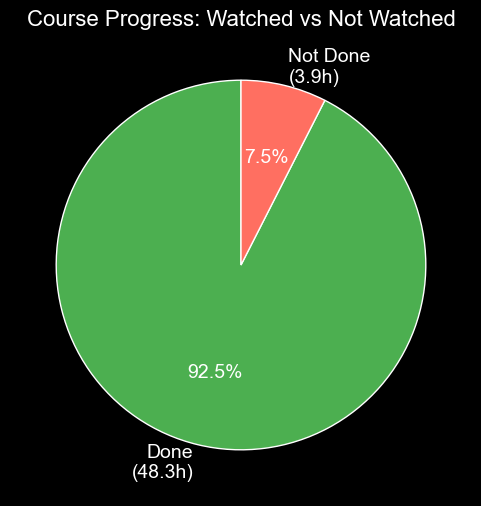

In [220]:
progress_pie_chart()